In [1]:
import torch.nn as nn
import torch


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(64, 192, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

Epoch [1/100], Loss: 2.8418, Accuracy: 0.0945
Epoch [2/100], Loss: 2.6061, Accuracy: 0.1709
Epoch [3/100], Loss: 2.2405, Accuracy: 0.2582
Epoch [4/100], Loss: 2.0424, Accuracy: 0.2545
Epoch [5/100], Loss: 1.8128, Accuracy: 0.3600
Epoch [6/100], Loss: 1.7425, Accuracy: 0.3745
Epoch [7/100], Loss: 1.6830, Accuracy: 0.3964
Epoch [8/100], Loss: 1.5154, Accuracy: 0.4873
Epoch [9/100], Loss: 1.4001, Accuracy: 0.4218
Epoch [10/100], Loss: 1.3031, Accuracy: 0.5127
Epoch [11/100], Loss: 1.1108, Accuracy: 0.5709
Epoch [12/100], Loss: 1.0800, Accuracy: 0.5200
Epoch [13/100], Loss: 1.1785, Accuracy: 0.5345
Epoch [14/100], Loss: 1.0581, Accuracy: 0.5782
Epoch [15/100], Loss: 0.8650, Accuracy: 0.5964
Epoch [16/100], Loss: 0.7865, Accuracy: 0.6473
Epoch [17/100], Loss: 0.7039, Accuracy: 0.6473
Epoch [18/100], Loss: 0.7213, Accuracy: 0.6109
Epoch [19/100], Loss: 0.6517, Accuracy: 0.6218
Epoch [20/100], Loss: 0.5327, Accuracy: 0.6182
Epoch [21/100], Loss: 0.5655, Accuracy: 0.6691
Epoch [22/100], Loss: 

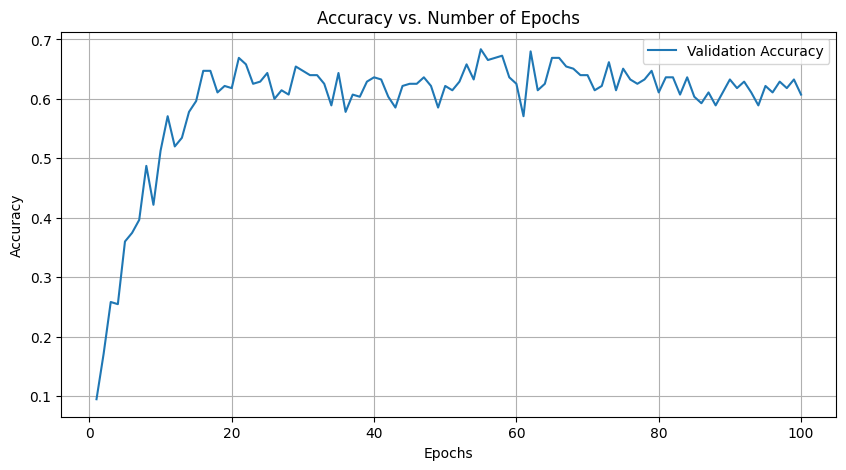

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt



class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # Create a dictionary to map class strings to integers
        self.label_map = {label: index for index, label in enumerate(sorted(set(self.data_frame.iloc[:, 1])))}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label_str = self.data_frame.iloc[idx, 1]
        # Use the label map to convert string labels to integers
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label
# Step 1: Define your transformations and datasets
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomDataset(
    csv_file='/content/drive/MyDrive/Colab Notebooks/labels.csv',
    root_dir='/content/drive/MyDrive/jpg',
    transform=transform
)

# Assuming a 80-20 split for train-validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 2: Initialize the AlexNet model
model = AlexNet(num_classes=17, init_weights=True)

# Step 3: Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)


# Initialize lists to track the loss and accuracy
epoch_losses = []
epoch_accuracies = []

for epoch in range(100):  # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate and store the average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    # Evaluate accuracy after each epoch
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = correct / total
    epoch_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch + 1}/100], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training')

# Plotting the graph of accuracy vs. number of epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), epoch_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

